In [1]:
#!pip install git+https://github.com/maurerv/pyzernike
#!pip install trimesh
#!pip install scipy
#!pip install matplotlib
#!pip install tdqm

In [2]:
import numpy as np
import trimesh

def obj_to_voxels_trimesh(obj_path: str, grid_size: int = 64, fill_interior: bool = True, pad: int = 2,) -> np.ndarray:
    """
    Load OBJ mesh and convert to a cubic voxel occupancy grid of shape (grid_size, grid_size, grid_size).
    Occupied voxels are 1.0, empty are 0.0 (float32), suitable for pyzernike.

    Notes:
    - For best results, mesh should be watertight if fill_interior=True.
    - grid_size=64..128 is typical. 128^3 can be heavy but still manageable.
    """
    mesh = trimesh.load(obj_path, force="mesh")

    # Ensure the mesh is in a reasonable state
    if mesh.is_empty:
        raise ValueError("Loaded mesh is empty. Check the OBJ path/content.")

    # Center the mesh at origin
    mesh = mesh.copy()
    mesh.apply_translation(-mesh.centroid)

    # Scale to fit into a unit cube-ish volume (we'll fit to [-0.5, 0.5] range)
    extents = mesh.extents
    scale = 1.0 / max(extents) if max(extents) > 0 else 1.0
    mesh.apply_scale(scale)

    # Voxelization resolution:
    # We choose pitch so that the largest dimension spans ~ (grid_size - 2*pad) voxels
    pitch = 1.0 / (grid_size - 2 * pad)

    # Voxelize surface
    vg = mesh.voxelized(pitch=pitch)

    if fill_interior:
        # Fill inside of the surface voxel shell (requires reasonably watertight mesh)
        vg = vg.fill()

    # vg.matrix is a boolean occupancy grid (axis order is consistent but can differ by library version)
    occ = vg.matrix.astype(np.float32)

    # Now we want a cube of exactly (grid_size, grid_size, grid_size).
    # We'll pad/crop around the center.
    def center_crop_or_pad(arr, target):
        out = np.zeros((target, target, target), dtype=np.float32)
        src = arr
        # compute start indices for source and dest
        src_shape = np.array(src.shape)
        tgt_shape = np.array(out.shape)
        src_start = np.maximum((src_shape - tgt_shape) // 2, 0)
        tgt_start = np.maximum((tgt_shape - src_shape) // 2, 0)
        size = np.minimum(src_shape, tgt_shape)

        out[
            tgt_start[0]:tgt_start[0]+size[0],
            tgt_start[1]:tgt_start[1]+size[1],
            tgt_start[2]:tgt_start[2]+size[2],
        ] = src[
            src_start[0]:src_start[0]+size[0],
            src_start[1]:src_start[1]+size[1],
            src_start[2]:src_start[2]+size[2],
        ]
        return out

    occ = center_crop_or_pad(occ, grid_size)

    return occ

In [3]:
import numpy as np
from pyzernike import ZernikeDescriptor
from pathlib import Path
from itertools import chain
from tqdm import tqdm


descriptors = []
names = []

obj_dir = [Path("data/OvisAries"), Path("data/GazellaSubgutturosa")]
files = chain.from_iterable(
    sorted(d.glob("*.obj")) for d in obj_dir
)

labels = []

for obj_path in tqdm(files):
    names.append(f"{obj_path.parent.name}-{obj_path.stem.rsplit('-', 1)[-1]}")
    labels.append(0 if str(obj_path).startswith("data\O") else 1)
    voxelObject = obj_to_voxels_trimesh(obj_path, grid_size=256, fill_interior=True) # grid-size 64, 128, 256
    descriptor = ZernikeDescriptor.fit(data=voxelObject, order=12) # order 8, 12, 16
    coefficients = descriptor.get_coefficients()
    descriptors.append(coefficients)

descriptors = np.vstack(descriptors)
descriptors

<>:20: SyntaxWarning: invalid escape sequence '\O'
<>:20: SyntaxWarning: invalid escape sequence '\O'
C:\Users\schueler\AppData\Local\Temp\ipykernel_1192\1948620604.py:20: SyntaxWarning: invalid escape sequence '\O'
  labels.append(0 if str(obj_path).startswith("data\O") else 1)
85it [11:29,  8.11s/it]


array([[1.64522365e-01, 3.96718320e-08, 2.26136088e-01, ...,
        1.95577722e-02, 9.69383586e-03, 1.30141398e-03],
       [1.61113769e-01, 2.51016115e-08, 2.20970169e-01, ...,
        2.05588918e-02, 1.10826669e-02, 1.26306282e-03],
       [1.72821820e-01, 6.73222829e-08, 2.31745467e-01, ...,
        2.01072562e-02, 1.39862448e-02, 1.64366269e-03],
       ...,
       [1.58328772e-01, 3.00663601e-08, 2.11663827e-01, ...,
        2.90071554e-02, 1.22421589e-02, 3.37043474e-03],
       [1.52441859e-01, 9.28903443e-09, 2.06624836e-01, ...,
        3.24255116e-02, 1.00242095e-02, 2.14688573e-03],
       [1.58971190e-01, 9.85510127e-08, 2.12648466e-01, ...,
        3.04982457e-02, 1.07558230e-02, 2.43389374e-03]], dtype=float32)

In [4]:
len(labels)

85

In [5]:
X = descriptors.astype(np.float64)

# Optional but recommended: normalize each descriptor (reduces magnitude effects)
X = X / np.linalg.norm(X, axis=1, keepdims=True)

# Pairwise Euclidean distances, shape (N, N)
D = np.linalg.norm(X[:, None, :] - X[None, :, :], axis=2)
S = 1.0 / (1.0 + D)
print(S)

[[1.         0.94979458 0.94932255 ... 0.90181175 0.90011302 0.90486288]
 [0.94979458 1.         0.93661973 ... 0.90563263 0.90995476 0.90957028]
 [0.94932255 0.93661973 1.         ... 0.90110327 0.89082086 0.9017419 ]
 ...
 [0.90181175 0.90563263 0.90110327 ... 1.         0.95672365 0.96621794]
 [0.90011302 0.90995476 0.89082086 ... 0.95672365 1.         0.96648787]
 [0.90486288 0.90957028 0.9017419  ... 0.96621794 0.96648787 1.        ]]


In [6]:
D.shape

(85, 85)

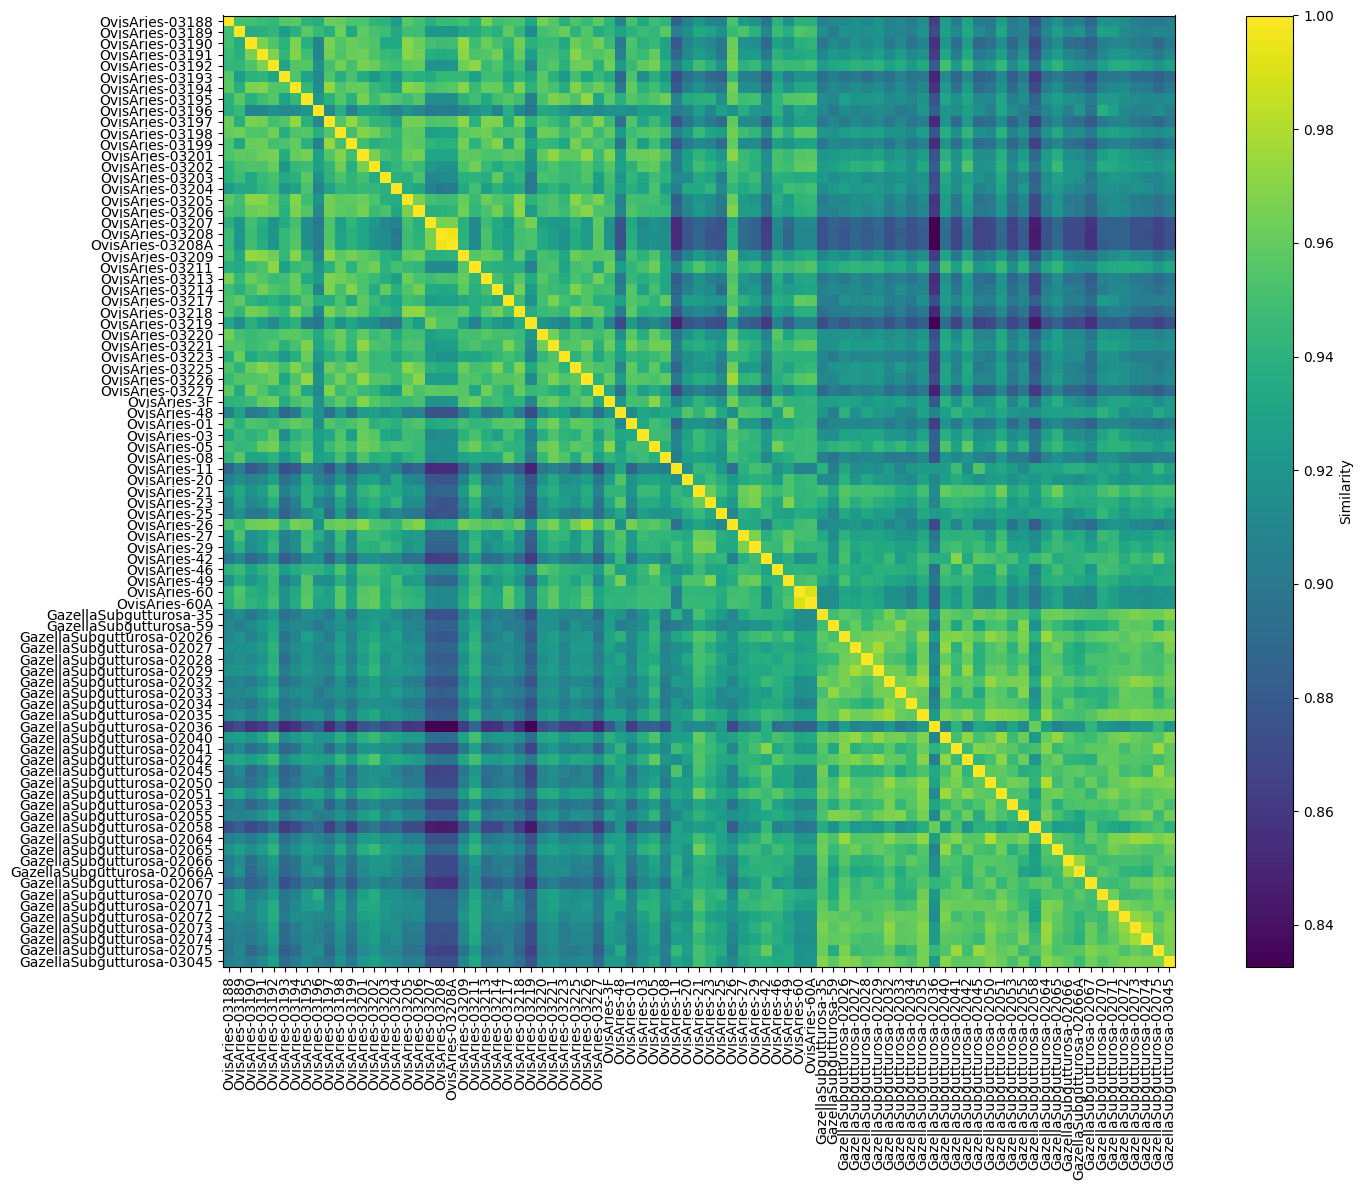

In [7]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(16, 12))

im = ax.imshow(S, interpolation="nearest")
cbar = fig.colorbar(im, ax=ax)
cbar.set_label("Similarity") # (1 / (1 + distance))")

#ax.set_title("Pairwise Similarity of Zernike descriptors")
#ax.set_xlabel("Scan")
#ax.set_ylabel("Scan")

# Tick labels (optional: for many items, this gets crowded)
ax.set_xticks(np.arange(len(names)))
ax.set_yticks(np.arange(len(names)))
ax.set_xticklabels(names, rotation=90)
ax.set_yticklabels(names)

plt.tight_layout()
#plt.savefig("pairwise_similarity_zernike-256-12.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [13]:
from sklearn.metrics import silhouette_score

# D must be symmetric, zeros on diagonal
score = silhouette_score(D, labels, metric="precomputed")
print(score)

0.3325706627227003


In [14]:
# 0.2734641457801125 mit gridsize 64 order 8
# 0.32281639539978974 mit gridsize 64 order 12
# 0.3151757780113928 mit gridsize 64 order 16

# 0.27790112125129895 mit gridsize 128 order 8
# 0.3281365534758684 mit gridsize 128 order 12
# 0.3201638249426556 mit gridsize 128 order 16

# 0.28291811592941385 mit gridsize 256 order 8
# 0.3325706627227003 mit gridsize 256 order 12  -- takes 11:29 min
# 0.32376689574598405 mit gridsize 256 order 16

In [15]:
# Save Descriptor for Classification
np.savez(
    "Descriptors/features_Zernike_grid256ord12.npz",
    X=X,
    y=labels,
    ids=names
)
print("Saved")

Saved
